# **Predictive Analytics: Shinkansen Passenger Satisfaction**

## Data Preprocessing

**1. Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.simplefilter("ignore")

**2. Load the training and test data separately**

In [2]:
#train data
surveydata_train = pd.read_csv("Surveydata_train.csv")
traveldata_train = pd.read_csv("Traveldata_train.csv")
#test data
surveydata_test = pd.read_csv("Surveydata_test.csv")
traveldata_test = pd.read_csv("Traveldata_test.csv")

**3. Understand the data (check for each of the following in both the train and test dataset)**
<ol>
<li>Check a sample of the data</li>
<li>Use the info() and describe() functions for more information</li>
<li>Look for the presence of null values in the dataset</li>
<li>Look for the presence of bad data or unwanted characters like "$" or "#" in the numerical columns</li>
</ol>

In [3]:
#A. Check a sample of the data
surveydata_train.sample(5)

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
33395,98833396,1,Poor,Ordinary,Poor,Poor,Inconvenient,Excellent,Good,Good,Good,Good,Good,Good,Good,Good,Good
74863,98874864,0,Poor,Green Car,Poor,Poor,Manageable,Good,Poor,Good,Good,Poor,Needs Improvement,Good,Poor,Acceptable,Good
52802,98852803,1,Poor,Green Car,NaN,Poor,Inconvenient,Good,Poor,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Excellent
48220,98848221,1,Acceptable,Green Car,Acceptable,Acceptable,Manageable,Good,Good,Good,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Needs Improvement,Acceptable
38485,98838486,1,Good,Green Car,Acceptable,Good,Convenient,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Needs Improvement,Poor,Needs Improvement,Excellent


In [4]:
#A. Check a sample of the data
traveldata_train.sample(5)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
116,98800117,Male,Loyal Customer,28.0,Business Travel,Business,2355,0.0,0.0
81217,98881218,Female,Loyal Customer,57.0,Personal Travel,Eco,1474,0.0,1.0
80215,98880216,Female,Loyal Customer,24.0,Personal Travel,Eco,2013,0.0,0.0
53043,98853044,Male,Loyal Customer,12.0,Personal Travel,Eco,2685,0.0,0.0
27615,98827616,Female,Loyal Customer,42.0,Business Travel,Business,1845,0.0,0.0


In [5]:
#B. Use the info() and describe() functions for more information
surveydata_train.info()
surveydata_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

,ID,Overall_Experience
count,9.437900e+04,94379.000000
mean,9.884719e+07,0.546658
std,2.724501e+04,0.497821
min,9.880000e+07,0.000000
25%,9.882360e+07,0.000000
50%,9.884719e+07,1.000000
75%,9.887078e+07,1.000000
max,9.889438e+07,1.000000


In [6]:
#B. Use the info() and describe() functions for more information
traveldata_train.info()
traveldata_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
count,9.437900e+04,94346.000000,94379.000000,94322.000000,94022.000000
mean,9.884719e+07,39.419647,1978.888185,14.647092,15.005222
std,2.724501e+04,15.116632,1027.961019,38.138781,38.439409
min,9.880000e+07,7.000000,50.000000,0.000000,0.000000
25%,9.882360e+07,27.000000,1359.000000,0.000000,0.000000
50%,9.884719e+07,40.000000,1923.000000,0.000000,0.000000
75%,9.887078e+07,51.000000,2538.000000,12.000000,13.000000
max,9.889438e+07,85.000000,6951.000000,1592.000000,1584.000000


In [7]:
#C. Look for the presence of null values in the dataset
surveydata_train.isnull().values.any()

True

In [8]:
#C. Look for the presence of null values in the dataset
traveldata_train.isnull().values.any()

True

In [9]:
#D. Look for the presence of bad data or unwanted characters like "$" or "#" in the numerical columns
surveydata_train.describe().columns.astype(str).str.contains("($|#)").any()

True

In [10]:
#D. Look for the presence of bad data or unwanted characters like "$" or "#" in the numerical columns
traveldata_train.describe().columns.astype(str).str.contains("($|#)").any()

True

**4. Clean the data**
<ol>
<li>Treat for missing values in both the train & test set</li>
<li>Remove bad data values in both the train & test set</li>
<li>Encode the categorical object variables in both the train & test set</li>
<li>Perform Feature Engineering if necessary</li>
<li>Scale/Normalize the dataset if necessary</li>
</ol>

In [11]:
def dataframe_cleaning(df):
    # Before cleaning any data, it is important to transform Categorical values to numerical values
    # Retrieve categorical columns, which have data type as "object"
    df_object_columns = df.select_dtypes(include=['object']).columns
    # One-hot encoding for categorical variables
    df_encoded = pd.get_dummies(df, columns=df_object_columns)#, dummy_na=True)
    #A. Treat for missing values in both the train & test set
    imputer = KNNImputer(n_neighbors=15)
    #np array is created
    df_imputed = imputer.fit_transform(df_encoded)
    #back to dataframe
    df_without_nans = pd.DataFrame(data=df_imputed, columns=df_encoded.columns)
    
    return df_without_nans

In [12]:
#train data
surveydata_train_clean = dataframe_cleaning(surveydata_train)
traveldata_train_clean = dataframe_cleaning(traveldata_train)
#test data
surveydata_test_clean = dataframe_cleaning(surveydata_test)
traveldata_test_clean = dataframe_cleaning(traveldata_test)

In [13]:
#if a column is not present on the test set, then it is not important in the train set. Sans the target variable "Overall_Experience"
def shape_equalizer(df1, df2):
    """train, then test"""
    df1_columns = df1.columns
    df2_columns = df2.columns
    difference = list(set(df1_columns).difference(set(df2_columns)))
    if "Overall_Experience" in difference:
        difference.pop(difference.index("Overall_Experience"))
    df1 = df1.drop(difference, axis=1)
    return df1, df2

In [14]:
#survey data
surveydata_train_equalized, surveydata_test_equalized = shape_equalizer(surveydata_train_clean, surveydata_test_clean)
#travel data
traveldata_train_equalized, traveldata_test_equalized = shape_equalizer(traveldata_train_clean, traveldata_test_clean)

In [15]:
if surveydata_train_equalized.shape[0] == traveldata_train_equalized.shape[0] and surveydata_test_equalized.shape[0] == traveldata_test_equalized.shape[0]:
    print("Same number of rows between survey and travel data sets.")

Same number of rows between survey and travel data sets.


In [16]:
# -1 due to target column "Overall_Experience"
if surveydata_train_equalized.shape[1]-1 == surveydata_test_equalized.shape[1] and traveldata_train_equalized.shape[1] == traveldata_test_equalized.shape[1]:
    print("Same number of columns between test and train data sets.")

Same number of columns between test and train data sets.


In [17]:
#last, join the two datasets for train and the two datasets for test
#train
train_data = traveldata_train_equalized.merge(surveydata_train_equalized, on='ID')
#test
test_data = traveldata_test_equalized.merge(surveydata_test_equalized, on='ID')

## try some feature engineering

In [18]:
def feature_eng(df):
    df['Delay_per_Distance'] = df['Departure_Delay_in_Mins'] / df['Travel_Distance']
    poly = PolynomialFeatures(degree=2, include_bias=False)
    df_poly = poly.fit_transform(df[['Age', 'Travel_Distance']])
    return df

## Model Building

In [54]:
rfc = RandomForestClassifier(bootstrap= False,
                             ccp_alpha= 0.0,
                             class_weight= None,
                             criterion= 'gini',
                             max_depth= None,
                             max_features= 'auto',
                             max_leaf_nodes= None,
                             max_samples= None,
                             min_impurity_decrease= 0.0,
                             min_samples_leaf= 1,
                             min_samples_split= 2,
                             min_weight_fraction_leaf= 0.0,
                             n_estimators= 2500,
                             n_jobs= -1,
                             oob_score= False,
                             random_state= 42,
                             verbose= 0,
                             warm_start= False)

In [55]:
xgb = XGBClassifier(objective= 'binary:logistic',
                    use_label_encoder= None,
                    base_score= None,
                    booster= None,
                    callbacks= None,
                    colsample_bylevel= None,
                    colsample_bynode= None,
                    colsample_bytree= 0.5,
                    early_stopping_rounds= None,
                    enable_categorical= False,
                    eval_metric= None,
                    feature_types= None,
                    gamma= 0.25,
                    gpu_id= None,
                    grow_policy= None,
                    importance_type= None,
                    interaction_constraints= None,
                    learning_rate= 0.09999999999999999,
                    max_bin= None,
                    max_cat_threshold= None,
                    max_cat_to_onehot= None,
                    max_delta_step= None,
                    max_depth= 15,
                    max_leaves= None,
                    min_child_weight= 2,
                    monotone_constraints= None,
                    n_estimators= 2000,
                    n_jobs= -1,
                    num_parallel_tree= None,
                    predictor= None,
                    random_state= 42,
                    reg_alpha= 0.1,
                    reg_lambda= 0.2,
                    sampling_method= None,
                    scale_pos_weight= None,
                    subsample= 0.9,
                    tree_method= None,
                    validate_parameters= None,
                    verbosity= None)

In [56]:
ext = ExtraTreesClassifier(bootstrap= False,
                           ccp_alpha= 0.0,
                           class_weight= None,
                           criterion= 'entropy',
                           max_depth= None,
                           max_features= 'auto',
                           max_leaf_nodes= None,
                           max_samples= None,
                           min_impurity_decrease= 0.0,
                           min_samples_leaf= 1,
                           min_samples_split= 2,
                           min_weight_fraction_leaf= 0.0,
                           n_estimators= 2500,
                           n_jobs= -1,
                           oob_score= False,
                           random_state= 42,
                           verbose= 0,
                           warm_start= False)

In [57]:
# save function for all
def results_to_csv(y_pred, var_name):
    data = test_data.copy()
    data['Overall_Experience'] = y_pred
    result = data[['ID', 'Overall_Experience']]
    #to integers
    result[['ID', 'Overall_Experience']] = result[['ID', 'Overall_Experience']].astype(int)
    #print head
    print(result.head(5))
    #save as csv
    name = "_".join(var_name.split('_')[-2:]) + '_result.csv'
    return result.to_csv(name, index=False)

#### something

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler()

# Create pipelines
#svm_pipeline = make_pipeline(scaler, svm)
rfc_pipeline = make_pipeline(scaler, rfc)
xgb_pipeline = make_pipeline(scaler, xgb)
ext_pipeline = make_pipeline(scaler, ext)

# Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

base_models = list()
base_models.append(('rfc', RandomForestClassifier()))
base_models.append(('xgb', XGBClassifier()))
base_models.append(('ext', ExtraTreesClassifier()))

meta_learner = LogisticRegression()

stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner, cv=5)



# Define the ensemble model
ensemble = VotingClassifier(estimators=[('Random Forest', rfc_pipeline),
                                        ('XGBoost', xgb_pipeline),
                                        ('ExtraTree', ext_pipeline),
                                        ('Stacked',stacked_model)], voting='soft')


#### model

In [69]:
train_data = feature_eng(train_data)
test_data = feature_eng(test_data)

In [70]:
# train, test, split for all
X = train_data.drop('Overall_Experience', axis=1)
y = train_data['Overall_Experience']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Fit the ensemble
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('Random Forest',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(bootstrap=False,
                                                                      max_features='auto',
                                                                      n_estimators=2500,
                                                                      n_jobs=-1,
                                                                      random_state=42))])),
                             ('XGBoost',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('xgbclassifier',
                                               XGBClassifier(base_score=None,
                                                             booster=N...
                                                                            learning_rate=None,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=None,
                                                                            max_leaves=None,
                                                                            min_child_weight=None,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            n_estimators=100,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            predictor=None,
                                                                            random_state=None, ...)),
                                                             ('ext',
                                                              ExtraTreesClassifier())],
                                                 final_estimator=LogisticRegression()))],
                 voting='soft')

In [72]:
# Train the model
y_pred_train = ensemble.predict(X_train)

In [73]:
# Evaluate model on training data
print(confusion_matrix(y_train, y_pred_train))

[[34381     0]
 [    0 41122]]


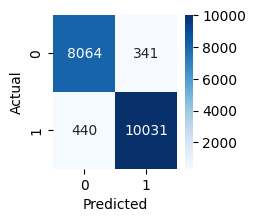

In [74]:
# Make predictions on validation data
y_pred_val = ensemble.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val)
#pretty plot
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels (depends on your problem)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [75]:
[[TN,FP],[FN,TP]] = cm
Accuracy = (TN + TP) / (TN + FP + FN + TP)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = 2 * (Precision * Recall) / (Precision + Recall)
maybe_acc = Accuracy - 0.003
target = 0.9568002
print(f"cm:\n{cm}\nAccuracy:\t{Accuracy:.7f}\nPrecision:\t{Precision:.7f}\nRecall:\t\t{Recall:.7f}\nF1_score:\t{F1_score:.7f}\n\nMaybe Acc:\t{maybe_acc:.7f}\nTarget:\t\t{target:.7f}")


cm:
[[ 8064   341]
 [  440 10031]]
Accuracy:	0.9586247
Precision:	0.9671230
Recall:		0.9579792
F1_score:	0.9625294

Maybe Acc:	0.9556247
Target:		0.9568002


In [76]:
# Make prediction
y_pred_test = ensemble.predict(test_data)
y_pred_test

array([1., 1., 1., ..., 0., 1., 0.])

In [77]:
results_to_csv(y_pred_test, "y_pred_test_voting_ensemble")

         ID  Overall_Experience
0  99900001                   1
1  99900002                   1
2  99900003                   1
3  99900004                   0
4  99900005                   1
